# Predicting Stock Price Using News Sentiments

***

## Objective:

Can we use the content of news analytics to predict stock price performance? The ubiquity of data today enables investors at any scale to make better investment decisions. The assignment is ingesting and interpreting the data to determine which data is useful, finding the signal in this sea of information.

***

## Data

The data is taken from [Kaggle](https://www.kaggle.com/aaron7sun/stocknews). In this assignment,we will be predicting future stock price returns based on two sources of data::

### News data (2008-06-08 to 2016-07-01): 

Crawled historical news headlines from [Reddit WorldNews Channel](https://www.reddit.com/r/worldnews/). They are ranked by reddit users' votes, and only the top 25 headlines are considered for a single date. 

### Market data (2008-08-08 to 2016-07-01): 

Dow Jones Industrial Average (DJIA) is used to "prove the concept". 

#### Files
Data is provided in three data files .csv format:

1. **RedditNews.csv**: two columns The first column is the "date", and second column is the "news headlines". All news are ranked from top to bottom based on how hot they are. Hence, there are 25 lines for each date.

2. **DJIA_table.csv**: Downloaded directly from [Yahoo Finance](https://finance.yahoo.com/quote/%5EDJI/history?p=%5EDJI): check out the web page for more info.

3. **Combined_News_DJIA.csv**: To make things easier for my students, I provide this combined dataset with 27 columns. The first column is "Date", the second is "Label", and the following ones are news headlines ranging from "Top1" to "Top25".

***

## Structure:

The notebook is briefly summarized as follows:

1. **Data Preparation** - Preparing data for evaluation.

2. **Data Exploration** - Performing basic checks on data for better understanding of data.

3. **Feature Engineering** - Correlation and feature Mutual information plots against the target variable. Inspection of the Binary, categorical and other variables.

4. **Feature Extraction**-  ranking via learning models

5. **Training** - training data against different machine learning algorthms and fine tuning a couple of algorithms for accuracy
6. **Prediction** - Prediction done using different time series model (eg. ARIMA etc)


In [1]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot

#from pandas import read_csv, set_option
from pandas import Series, datetime
from pandas.tools.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
import seaborn as sns


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 1. Data Preparation:

Imported all the necessary modules for the project

Loaded the dataset as a dataframe and parsed the date column to be read by the dataframe as dates type
Checked the top 5 rows of the dataframe to see how the columns are aligned.


The 'combined_stock_data.csv' initially only had the headlines(Top1 through Top25). Each row was iterated over an algorithm which generated the Subjectivity, Objectivity, Positive, Negative, Neutral sentiments of the respective headlines of each row.

The algorithm was accepting only a single sentence and was providing the respective sentiments in percentage. I modified the algorithm iterate over all of the individuals rows and simultaneously create the Subjectivity, Objectivity, Negative, Positive, Neutral values and assign itself to the columns in the dataframe.

The headlines Top1 through Top25 were concatenated and then passed on to the algorithm

Algorithm Used : [Sentiment](https://github.com/ShreyamsJain/Stock-Price-Prediction-Model/blob/master/Sentence_Polarity/sentiment.py) avaiable at github


### 1.1 News Data



In [3]:
# Loading the dataset to a dataframe
sentence_file = "../data/SPSA/combined_stock_data.csv"
sentence_df = pd.read_csv(sentence_file, parse_dates=[1])

In [4]:
sentence_df.head()

,Unnamed: 0,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,...,Top22,Top23,Top24,Top25,Para,Subjectivity,Objectivity,Positive,Neutral,Negative
0,0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...",...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""","b""Georgia 'downs two Russian warplanes' as cou...",75.000000,25.000000,18.750000,25.000000,56.250000
1,1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",b'Why wont America and Nato help us? If they w...,83.333333,16.666667,41.666667,16.666667,41.666667
2,2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,...,b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",b'Remember that adorable 9-year-old who sang a...,56.250000,43.750000,18.750000,43.750000,37.500000
3,3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",...,b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,b' U.S. refuses Israel weapons to attack Iran:...,38.461538,61.538462,15.384615,61.538462,23.076923
4,4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,...,b'Taliban wages war on humanitarian aid workers',"b'Russia: World ""can forget about"" Georgia\'s...",b'Darfur rebels accuse Sudan of mounting major...,b'Philippines : Peace Advocate say Muslims nee...,b'All the experts admit that we should legalis...,45.454545,54.545455,36.363636,54.545455,9.090909


If we look at the datatypes of all of the columns, we see that they are of object types. But it doesn't matter here as we are not going to use that data, instead we are going to use the polarity data that was produced by that data.

In [6]:
# Check the shape and data types of the dataframe
print(sentence_df.shape)
print(sentence_df.dtypes)

(1989, 34)
Unnamed: 0               int64
Date            datetime64[ns]
Label                    int64
Top1                    object
Top2                    object
Top3                    object
Top4                    object
Top5                    object
Top6                    object
Top7                    object
Top8                    object
Top9                    object
Top10                   object
Top11                   object
Top12                   object
Top13                   object
Top14                   object
Top15                   object
Top16                   object
Top17                   object
Top18                   object
Top19                   object
Top20                   object
Top21                   object
Top22                   object
Top23                   object
Top24                   object
Top25                   object
Para                    object
Subjectivity           float64
Objectivity            float64
Positive               float

#### 1.2 Market Data
Let's load the Dow Jones dataset to a dataframe stock_data which contains 8 years of Stock Price data. The, we parse the date as a date type and check the top 5 rows of the dataframe to get a basic sense of how the data looks like, it relationaship, variance in general.

In [7]:
# Load the stock prices dataset into a dataframe and check the top 5 rows
stock_prices = "../data/SPSA/DJIA_table.csv"
stock_data = pd.read_csv(stock_prices, parse_dates=[0])
stock_data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


It looks like we have one of the columns that has is of type int. Lets change the data type of the column of type int to type float, this is to maintain uniformity accross columns when performing arithmatic operations

In [8]:
# Check the shape and datatypes of the stock prices dataframe
print(stock_data.shape)
print(stock_data.dtypes)

(1989, 7)
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume                int64
Adj Close           float64
dtype: object


#### 1.3 Merging Data

We now merge the 5 columns(Subjectivity, Objectivity, Positive, Negative, Neutral) with the stock_data dataframe. Then, we validate the merged dataframe to see the 2 dataframes are concatenated by checking the top 5 rows of the merged_dataframe.

Lets take a look at the head of the newly merged data set, again just to get a basic sense of how the data could be correlated, the range of the data and also to see if the operation(merging dataset) we performed is fine.

In [9]:
# Create a dataframe by merging the headlines and the stock prices dataframe
merged_dataframe = sentence_df[['Date', 'Label', 'Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']].merge(stock_data, how='inner', on='Date', left_index=True)
# Check the shape and top 5 rows of the merged dataframe
print(merged_dataframe.shape)
merged_dataframe.head()

(1989, 13)


,Date,Label,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close
1988,2008-08-08,0,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
1987,2008-08-11,1,83.333333,16.666667,41.666667,41.666667,16.666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
1986,2008-08-12,0,56.250000,43.750000,18.750000,37.500000,43.750000,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
1985,2008-08-13,0,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
1984,2008-08-14,1,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688


In [12]:
# Push the Label column to the end of the dataframe
cols = list(merged_dataframe)
print(cols)
cols.append(cols.pop(cols.index('Label')))
merged_dataframe = merged_dataframe.loc[:, cols]
merged_dataframe.head()

['Date', 'Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Label']


,Date,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,Label
1988,2008-08-08,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,0
1987,2008-08-11,83.333333,16.666667,41.666667,41.666667,16.666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,1
1986,2008-08-12,56.250000,43.750000,18.750000,37.500000,43.750000,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,0
1985,2008-08-13,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,0
1984,2008-08-14,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,1


Also, We see that the volumn column in Integer format. Lets change it to float, same as the rest of the columns so we do not have any difficulties in making calculations at a later point.


In [13]:
# Change the datatype of the volume column to float
#merged_dataframe['Date'] = pd.to_datetime(merged_dataframe['Date'])
merged_dataframe['Volume'] = merged_dataframe['Volume'].astype(float)
print(cols)
#merged_dataframe = merged_dataframe.set_index(['Date'])
merged_dataframe.index = merged_dataframe.index.sort_values()
merged_dataframe.head()

['Date', 'Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Label']


,Date,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,Label
0,2008-08-08,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000.0,11734.320312,0
1,2008-08-11,83.333333,16.666667,41.666667,41.666667,16.666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000.0,11782.349609,1
2,2008-08-12,56.250000,43.750000,18.750000,37.500000,43.750000,11781.700195,11782.349609,11601.519531,11642.469727,173590000.0,11642.469727,0
3,2008-08-13,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000.0,11532.959961,0
4,2008-08-14,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000.0,11615.929688,1


## 2. Data Exploration/Sanity Check:

Lets Check the statistics of individual columns in the dataframe. As you can see below there are no outliers in any of the columns, however, some of the columns have NaN values. The NaN values are mostly dummy variables and it is important for those to be replaced. 

The NaN values could cause the classifier to predict incorrectly. It can be observed from the below data that there are about 3 NaN values in each of the Polaity columns data i.e (Subjectivity, Objectivity, Positive, Negative, Neutral).

We will replace the NaN in the cells below. Since we have only 3 NaN values, its impact on the data is going to be relatively less. So, in this case I am going to just replace the NaN's with the Mean value of the respective column as that would be the most appropriate decision in this case.

In [14]:
# Check the statistics of the columns of the merged dataframe and check for outliers
print(merged_dataframe.describe())

       Subjectivity  Objectivity     Positive     Negative      Neutral  \
count   1986.000000  1986.000000  1986.000000  1986.000000  1986.000000   
mean      56.712522    43.287478    19.966718    36.745804    43.287478   
std       21.557927    21.557927    16.373424    21.109970    21.557927   
min        0.000000     0.000000     0.000000     0.000000     0.000000   
25%       40.000000    28.571429     8.333333    21.859903    28.571429   
50%       54.545455    45.454545    18.181818    33.333333    45.454545   
75%       71.428571    60.000000    28.571429    50.000000    60.000000   
max      100.000000   100.000000   100.000000   100.000000   100.000000   

               Open          High           Low         Close        Volume  \
count   1989.000000   1989.000000   1989.000000   1989.000000  1.989000e+03   
mean   13459.116048  13541.303173  13372.931728  13463.032255  1.628110e+08   
std     3143.281634   3136.271725   3150.420934   3144.006996  9.392343e+07   
min     

#### 2.1 Histogram 

Plotted histograms for individual columns to see the distribution of values.


The plot below gives a fair idea of how the data is distributed across columns. We can see that most of the columns though not normally distributed are fairly evenly distributed across all the columns which is a good sign as we do not have to skew much with the data.

The Label column has only 0's and 1's. The distribution of this column is most important to be checked. We can see that spread of 0's and 1's are almost equal with the 0's being a little less than the 1's. But a slight difference doesnt matter much. A higher difference will require further transformations to be performed for the data to be equally distributed.

We need to have equal number of classifier variables because, even if one of the classifier variables are very low, the classifier will lead to bias and will find difficulty in predicting that particular variable. This will lead to the model predicting only the variable with higher distribution.

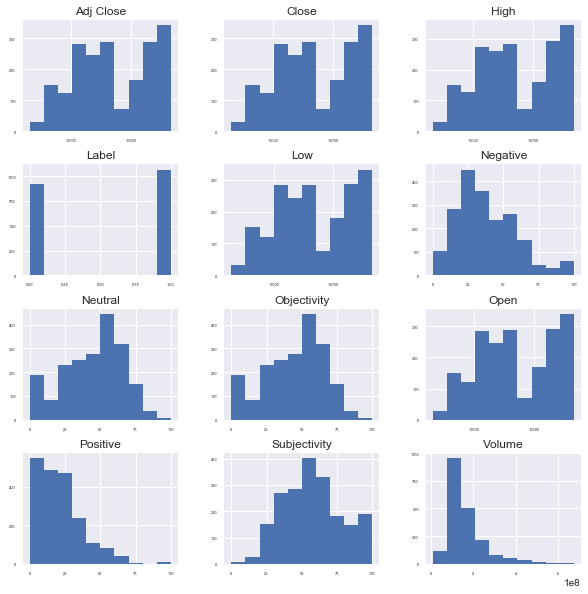

In [15]:
# Plot a histogram for all the columns of the dataframe. This shows the frequency of values in all the columns
sns.set()
merged_dataframe.hist(sharex = False, sharey = False, xlabelsize = 4, ylabelsize = 4, figsize=(10, 10))
pyplot.show()

#### Plot 1: Scatter plot of Stock Prices vs the Subjectivity.<br/>
        Stock Value of 0 means the Stock Value reduced since the previous day.<br/>
        Stock Value of 1 means the Stock Value increased or remained the same since the previous day.

#### Plot 2: Scatter plot of Stock Prices vs the Objectivity.<br/>
        Stock Value of 0 means the Stock Value reduced since the previous day.<br/>
        Stock Value of 1 means the Stock Value increased or remained the same since the previous day.

#### Plot 3: Histogram of Subjectivity column.<br/>
        The x axis are the values of Subjectivity and y axis is its respective frequency.<br/>
        The plot seems to be normally distributed.

#### Plot 4: Histogram of Objectivity column.<br/>
        The x axis are the values of Objectivity and y axis is its respective frequency.<br/>
        The plot seems to be normally distributed.<br/>


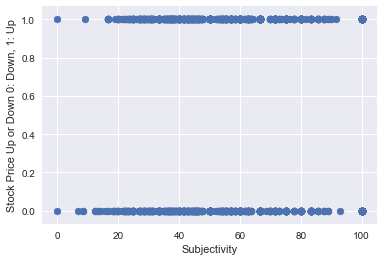

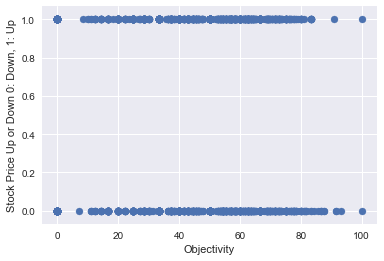

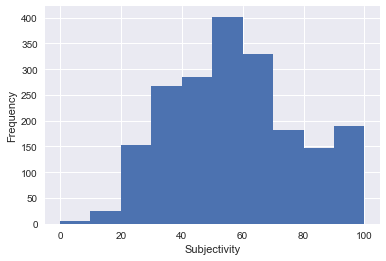

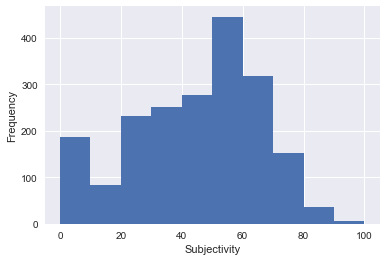

Size of the Labels column
Label
0     924
1    1065
dtype: int64


In [16]:
pyplot.scatter(merged_dataframe['Subjectivity'], merged_dataframe['Label'])
pyplot.xlabel('Subjectivity')
pyplot.ylabel('Stock Price Up or Down 0: Down, 1: Up')
pyplot.show()
pyplot.scatter(merged_dataframe['Objectivity'], merged_dataframe['Label'])
pyplot.xlabel('Objectivity')
pyplot.ylabel('Stock Price Up or Down 0: Down, 1: Up')
pyplot.show()
merged_dataframe['Subjectivity'].plot('hist')
pyplot.xlabel('Subjectivity')
pyplot.ylabel('Frequency')
pyplot.show()
merged_dataframe['Objectivity'].plot('hist')
pyplot.xlabel('Subjectivity')
pyplot.ylabel('Frequency')
pyplot.show()
print("Size of the Labels column")
print(merged_dataframe.groupby('Label').size())

## 3.Feature Engineering 

 Lets check for NaN values in individual columns of the dataframe.

Visualizing the NaN's makes it easier for us to see where the NaN values are falling. Below is a plot of the NaN values. The white lines are the NaN values. In the below plot we are unable to see the NaN values because they are so less. We just have 3 NaN values in the first 4 columns each. The perpendicular bars on the last vertical lin shows exactly where the NaN values are falling.

In this case, since the NaN values are so less, it doesn't matter much in the prediction of the model. However, it is important for the NaN values to be replaced. As discuseed earlier, we will replace the NaN values with the mean value of the respective column.

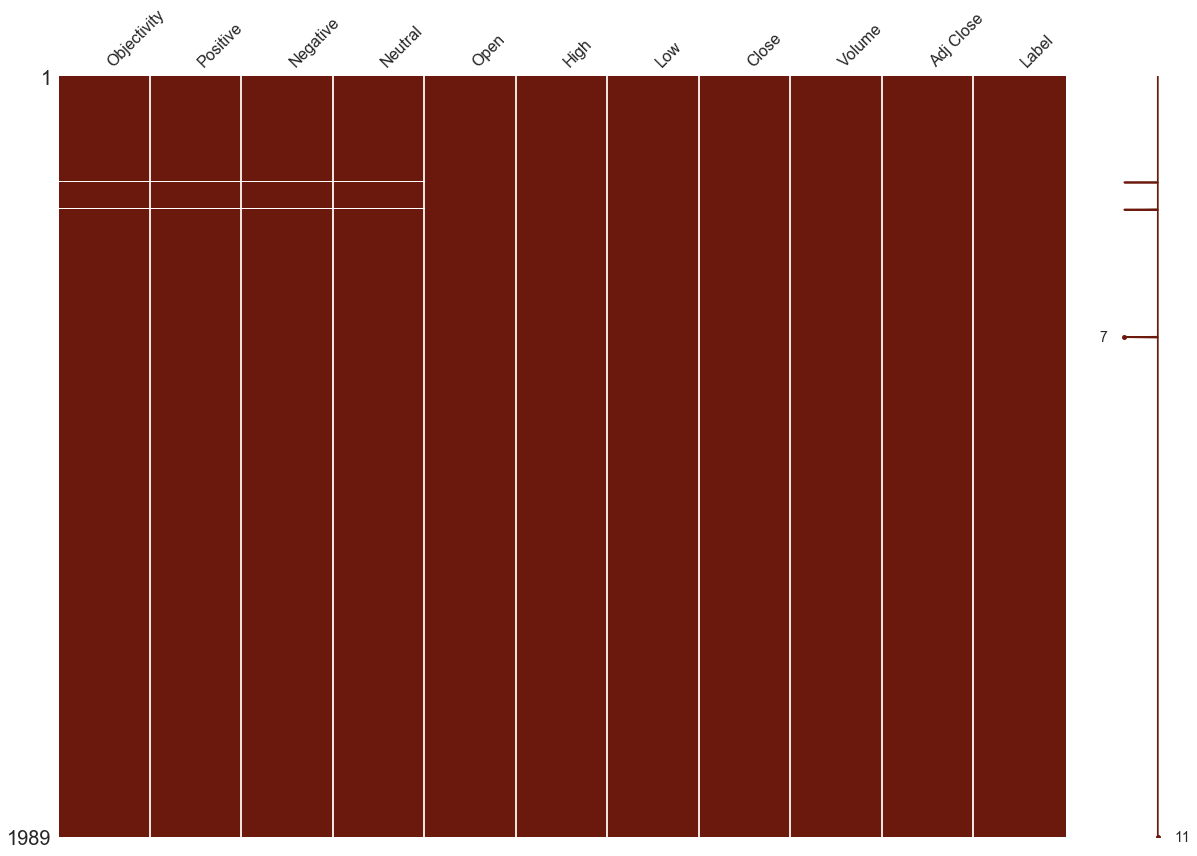

In [18]:
md_copy = merged_dataframe
md_copy = md_copy.replace(-1, np.NaN)
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df=md_copy.iloc[:,2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

## Correlation Map for features:

#### Now, we will plot a heat map and a scatter matrix to see the correlation of the columns with each other.

#### You can see the heat map with pearson correlation values in the plot below.

#### This gave me a better understanding to see if there are any dependant variables or if any of the variables are highly correlated.

#### Some variables Subjectivity, Objectivity are negatively correlated. There are very few variables which seem to have a very high correlation. Thus, at this point we can conclude that we do not need any sort of dimensionality reduction technique to be applied.

#### Some machine learning algorithms require the predictor variables to not be highly correlated. If the predictors are highly correlated then all of the correlated predictors are basically representing the same correlation and either one or all the variables will have the same effect on the target variable. In such a case dimensionality reduction is required. 

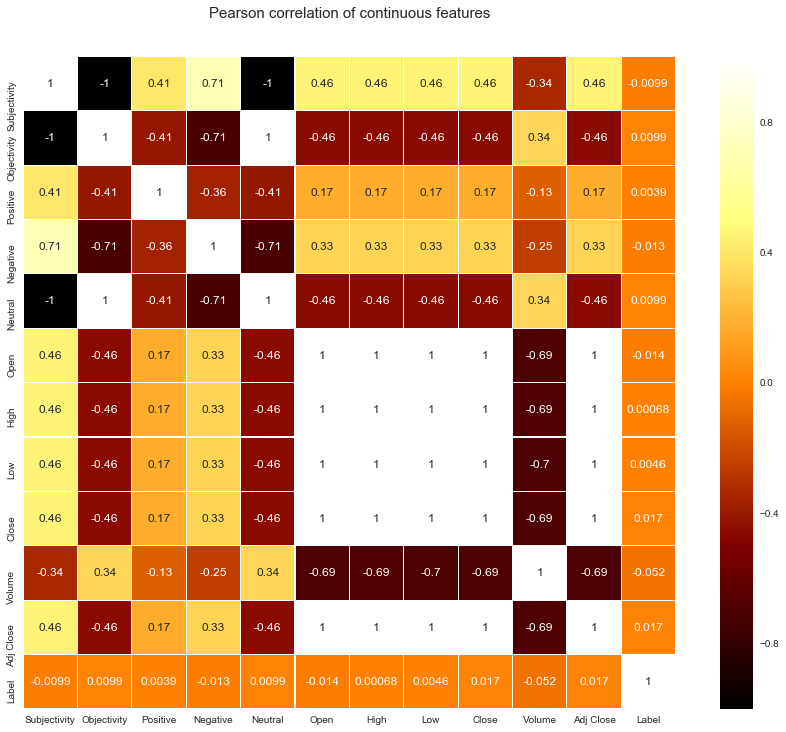

In [19]:
colormap = pyplot.cm.afmhot
pyplot.figure(figsize=(16,12))
pyplot.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(merged_dataframe.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)
pyplot.show()

In [20]:
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings

bin_col = merged_dataframe.columns
zero_list = []
one_list = []
for col in bin_col:
    zero_count = 0
    one_count = 0
    for ix, val in merged_dataframe[col].iteritems():
        if merged_dataframe.loc[ix, 'Label'] == 0:
            zero_count += 1
        else:
            one_count += 1
    zero_list.append(zero_count)
    one_list.append(one_count)
    
trace1 = go.Bar(
    x=bin_col,
    y=zero_list ,
    name='Zero count'
)
trace2 = go.Bar(
    x=bin_col,
    y=one_list,
    name='One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

## 4. Training:

### Steps being performed in the below cell:

Recheck the dataframe to see if the dataset is ready for train.

There are certain NaN values in many columns of the dataframe.

Replace the NaN values with the mean values of the respective column.

Split the merged dataframe to inputs(X) and outputs(y)

In our dataset, we have columns Subjectivity through Adj Close as inputs and the Label column output.

Now, we will split our dataset to training and test samples. Lets train out model on first 70% of the data 
and test our prediction model on remaining 30% of the data.

As this is a time series, it is important we do not randomly pick training and testing samples. A time series is a linear dataset where the data is in a chronological order. This requires the chronology to be preserved in while training the model and doing the prediction. This is why it is important to maintain a proper chronological split.

#### Lets consider a few machine learning algorithms to perform our training on.

Logistic Regression

Linear Discriminant Analysis

K Nearest Neighbors

Decision trees

Naive Bayes

Support Vector Classifier

Random Forest Classifier

#### Lets add all of these classifiers to a list 'models'

After splitting the dataset, we can see that there are 1393 samples for training and 597 samples for testing


Date            datetime64[ns]
Subjectivity           float64
Objectivity            float64
Positive               float64
Negative               float64
Neutral                float64
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                 float64
Adj Close              float64
Label                    int64
dtype: object
Date            1989
Subjectivity    1986
Objectivity     1986
Positive        1986
Negative        1986
Neutral         1986
Open            1989
High            1989
Low             1989
Close           1989
Volume          1989
Adj Close       1989
Label           1989
dtype: int64
Date            1989
Subjectivity    1989
Objectivity     1989
Positive        1989
Negative        1989
Neutral         1989
Open            1989
High            1989
Low             1989
Close           1989
Volume          1989
Adj Close       1989
Label           1989
dtype: int64
1989
1392
O

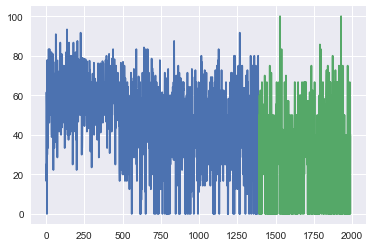

In [21]:
# Print the datatypes and count of the dataframe
print(merged_dataframe.dtypes)
print(merged_dataframe.count())
# Change the NaN values to the mean value of that column
nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
for col in nan_list:
    merged_dataframe[col] = merged_dataframe[col].fillna(merged_dataframe[col].mean())

# Recheck the count
print(merged_dataframe.count())
# Separate the dataframe for input(X) and output variables(y)
X = merged_dataframe.loc[:,'Subjectivity':'Adj Close']
y = merged_dataframe.loc[:,'Label']
# Set the validation size, i.e the test set to 20%
validation_size = 0.20
# Split the dataset to test and train sets
# Split the initial 70% of the data as training set and the remaining 30% data as the testing set
train_size = int(len(X.index) * 0.7)
print(len(y))
print(train_size)
X_train, X_test = X.loc[0:train_size, :], X.loc[train_size: len(X.index), :]
y_train, y_test = y[0:train_size+1], y.loc[train_size: len(X.index)]
print('Observations: %d' % (len(X.index)))
print('X Training Observations: %d' % (len(X_train.index)))
print('X Testing Observations: %d' % (len(X_test.index)))
print('y Training Observations: %d' % (len(y_train)))
print('y Testing Observations: %d' % (len(y_test)))
pyplot.plot(X_train['Objectivity'])
pyplot.plot([None for i in X_train['Objectivity']] + [x for x in X_test['Objectivity']])
pyplot.show()
num_folds = 10
scoring = 'accuracy'
# Append the models to the models list
models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NB' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
models.append(('XGBoost', XGBClassifier()))

#### Now, we will iterate over all of the machine learning classifiers and in each loop , we will train against the algorithm, predict the outputs with inputs from the testing split.

#### The process of training involves each individual model learning from its predictors and the respective output. Once the model learns it, the model is ready to perform the prediction. The prediction is performed on the testing set without giving away the output of the testing set to the model.

#### The actual and the predicted outputs are compared to calculate the accuracy.

#### We see that LDA seems to be giving a high accuracy score, but accuracy is still not the most trustworthy measure.


In [17]:
# Evaluate each algorithm for accuracy
results = []
names = []
'''
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg) '''

for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accu_score = accuracy_score(y_test, y_pred)
    print(name + ": " + str(accu_score))

LR: 0.530988274707
LDA: 0.943048576214


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning:

Variables are collinear.



KNN: 0.458961474037
CART: 0.579564489112
NB: 0.532663316583
SVM: 0.530988274707
RF: 0.546063651591
XGBoost: 0.586264656616


#### As data distributions are in varying ranges, it would be good to scale all of our data and then use it to train our algorithm.

#### The numerical range in each of the columns are in different ranges. Sometimes getting all the data in all columns to the same range helps better train the model. We can use a method StandardScalar to scale the data.

#### Lets print out the accuracy score, confusion matrix.

#### Below we are scaling the data and training using LDA and XGBoost. It can be seen that even after scaling the data the accuracy hasn't changed much and is still at 94% and 58% accuracy respectively for LDA and XGBoost.

#### Though LDA is giving an accuracy of 94%, it cannot fully be trusted. In the cells ahead, we will check the AUC score to measure the accuracy and further fine tune XGBoost.

In [22]:
# prepare the model LDA
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_lda.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))

model_xgb = XGBClassifier()
model_xgb.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_xgb.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))


accuracy score:
0.9430485762144054
confusion matrix: 
[[254  26]
 [  8 309]]
classification report: 
             precision    recall  f1-score   support

          0       0.97      0.91      0.94       280
          1       0.92      0.97      0.95       317

avg / total       0.94      0.94      0.94       597

accuracy score:
0.5862646566164154
confusion matrix: 
[[ 36 244]
 [  3 314]]
classification report: 
             precision    recall  f1-score   support

          0       0.92      0.13      0.23       280
          1       0.56      0.99      0.72       317

avg / total       0.73      0.59      0.49       597



C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning:

Variables are collinear.

C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



#### In the cell below, we are calculating the AUC score and plotting the ROC AUC curve. This is done to checking if LDA is performing well or not.

#### The curve plots a line and the higher the area under the curved line, the better the model.

#### We can see below that the AUC score is 0.5 and the under the curve as seen is about 50%. This score is worthless and and explains that the LDA is badly trained. The AUC score has to be more than 0.5 and the higher the score, the better the performance. A score of 0.5 only shows that LDA is a worthless model.

roc auc is :0.5


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:510: RuntimeWarning:

overflow encountered in exp



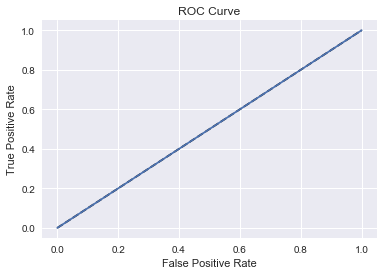

AUC using cross val: [0.99553571 0.99412456 0.96205357 0.97058824 1.         0.99221357
 0.99777531 0.995338   0.99642857 0.97685185]
Mean AUC score is: 0.988090937549825


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning:

Variables are collinear.

C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning:

Variables are collinear.

C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning:

Variables are collinear.

C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning:

Variables are collinear.

C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning:

Variables are collinear.

C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning:

Variables are collinear.

C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning:

Vari

In [23]:
# Generating the ROC curve
y_pred_proba = model_lda.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()

# AUC score using cross validation
kfold_val = KFold(n_splits=num_folds, random_state=42)
auc_score = cross_val_score(model_lda, X_test, y_test, cv=kfold_val, scoring='roc_auc')
print("AUC using cross val: " + str(auc_score))
mean_auc = np.mean(auc_score)
print("Mean AUC score is: " + str(mean_auc))

In [24]:
# Scaling Random Forests

model_rf = RandomForestClassifier(n_estimators=1000)
model_rf.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_rf.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))


accuracy score:
0.5611390284757118
confusion matrix: 
[[133 147]
 [115 202]]
classification report: 
             precision    recall  f1-score   support

          0       0.54      0.47      0.50       280
          1       0.58      0.64      0.61       317

avg / total       0.56      0.56      0.56       597



## 5. Feature Selection:

#### Below you can find the feature with highest to least important features plotted in the graph.

#### This is for XGBoost. We are using the feature importance function provided by XGBoost to check which are the predictor variables which have the highest effect on training the model. This is done to check if some of the predictor variables which have the least effect on training can be removed. Once the least effective predictors are removed, the model can be trained again which usually leads to better accuracy.

#### Below we can see that 'Low' and 'Neutral' columns have the highest effect in training the model.

#### There are other columns 'Close', 'Objectivity', 'Date', 'Positive' which have certain effect in the model, but the remaining columns do not have any effect and can thus be ignored.

#### In the cells ahead, we will try removing the non effective columns and train again to see if the accuracy of the model can be improved.

In [25]:
features = merged_dataframe.drop(['Label'],axis=1).columns.values

x, y = (list(x) for x in zip(*sorted(zip(model_xgb.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Feature importance for XGBoost',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances for XGBoost',
     width = 1000, height = 1000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')


#### Below is the feature importance graph for Random Forests.

#### This is just to see the sample important features for Random Forests. We are not going to use Random Forests for further tuning our model.

In [26]:
x, y = (list(x) for x in zip(*sorted(zip(model_rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Feature importance for Random Forests',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances for Random Forests',
     width = 1000, height = 1000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')


## Fine Tuning XGBoost

#### As of now the model that seems to be performing the best is the XGBoost model.

#### Lets see if we can fine tune it further to increase the accuracy of the model.

#### The main parameters which can be used for fine tuning the XGBoost model are the n_estimators and the max_depth parameters.

#### n_estimators: XGBoost is an additive model, multiple models are created on different samples of data and the model learns after training of different samples. How many samples are the optimum best for the XGBoost to train from is usually unknown and the best way to find out is to check by training on different set of estimators.

#### Lets take a list of n_estimators = [150, 200, 250, 450, 500, 550, 1000]

#### max_depth: XGBoost learns in the form of a tree model and the number of depths for that tree needs to be set. This parameter is also not known. So lets try on multiple set of depths.
#### max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

#### Below , we are training the XGBoost classifier on different combinations of max depth and estimators. This output will print out the  best parameters as well as the highest accuracy achieved using those parameters.

#### Below we can see that the accuracy has improved by around ~5%, i. e from 58% to 62% at 550 estimators and max depth of 3.

In [27]:
# XGBoost on Stock Price dataset, Tune n_estimators and max_depth
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib

matplotlib.use('Agg')
model = XGBClassifier()
n_estimators = [150, 200, 250, 450, 500, 550, 1000]
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
print(max_depth)
best_depth = 0
best_estimator = 0
max_score = 0
for n in n_estimators:
    for md in max_depth:
        model = XGBClassifier(n_estimators=n, max_depth=md)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        if score > max_score:
            max_score = score
            best_depth = md
            best_estimator = n
        print("Score is " + str(score) + " at depth of " + str(md) + " and estimator " + str(n))
print("Best score is " + str(max_score) + " at depth of " + str(best_depth) + " and estimator of " + str(best_estimator))


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning:


This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\p

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Score is 0.5711892797319933 at depth of 1 and estimator 150
Score is 0.5879396984924623 at depth of 2 and estimator 150


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5879396984924623 at depth of 3 and estimator 150
Score is 0.5879396984924623 at depth of 4 and estimator 150


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5829145728643216 at depth of 5 and estimator 150


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5879396984924623 at depth of 6 and estimator 150


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.592964824120603 at depth of 7 and estimator 150


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5829145728643216 at depth of 8 and estimator 150


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5795644891122278 at depth of 9 and estimator 150


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5963149078726968 at depth of 10 and estimator 150


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.592964824120603 at depth of 11 and estimator 150


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5912897822445561 at depth of 12 and estimator 150
Score is 0.5778894472361809 at depth of 1 and estimator 200


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5896147403685092 at depth of 2 and estimator 200
Score is 0.5912897822445561 at depth of 3 and estimator 200


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.592964824120603 at depth of 4 and estimator 200


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5795644891122278 at depth of 5 and estimator 200


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5896147403685092 at depth of 6 and estimator 200


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5946398659966499 at depth of 7 and estimator 200


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5879396984924623 at depth of 8 and estimator 200


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5695142378559463 at depth of 9 and estimator 200


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.592964824120603 at depth of 10 and estimator 200


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5896147403685092 at depth of 11 and estimator 200


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.592964824120603 at depth of 12 and estimator 200
Score is 0.576214405360134 at depth of 1 and estimator 250


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5912897822445561 at depth of 2 and estimator 250


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5963149078726968 at depth of 3 and estimator 250


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5912897822445561 at depth of 4 and estimator 250


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5829145728643216 at depth of 5 and estimator 250


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5862646566164154 at depth of 6 and estimator 250


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5879396984924623 at depth of 7 and estimator 250


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5812395309882747 at depth of 8 and estimator 250


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5561139028475712 at depth of 9 and estimator 250


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5912897822445561 at depth of 10 and estimator 250


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5812395309882747 at depth of 11 and estimator 250


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5896147403685092 at depth of 12 and estimator 250
Score is 0.576214405360134 at depth of 1 and estimator 450


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5896147403685092 at depth of 2 and estimator 450


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.6030150753768844 at depth of 3 and estimator 450


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5896147403685092 at depth of 4 and estimator 450


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.592964824120603 at depth of 5 and estimator 450


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5896147403685092 at depth of 6 and estimator 450


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5812395309882747 at depth of 7 and estimator 450


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5829145728643216 at depth of 8 and estimator 450


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5611390284757118 at depth of 9 and estimator 450


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5778894472361809 at depth of 10 and estimator 450


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5845896147403685 at depth of 11 and estimator 450


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5812395309882747 at depth of 12 and estimator 450
Score is 0.5795644891122278 at depth of 1 and estimator 500


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5946398659966499 at depth of 2 and estimator 500


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.6164154103852596 at depth of 3 and estimator 500


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.592964824120603 at depth of 4 and estimator 500


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5912897822445561 at depth of 5 and estimator 500


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5946398659966499 at depth of 6 and estimator 500


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5845896147403685 at depth of 7 and estimator 500


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5829145728643216 at depth of 8 and estimator 500


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5644891122278057 at depth of 9 and estimator 500


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5812395309882747 at depth of 10 and estimator 500


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5812395309882747 at depth of 11 and estimator 500


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5845896147403685 at depth of 12 and estimator 500
Score is 0.5795644891122278 at depth of 1 and estimator 550


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5912897822445561 at depth of 2 and estimator 550


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.6164154103852596 at depth of 3 and estimator 550


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5979899497487438 at depth of 4 and estimator 550


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5912897822445561 at depth of 5 and estimator 550


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5845896147403685 at depth of 6 and estimator 550


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5845896147403685 at depth of 7 and estimator 550


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5795644891122278 at depth of 8 and estimator 550


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5695142378559463 at depth of 9 and estimator 550


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5778894472361809 at depth of 10 and estimator 550


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5812395309882747 at depth of 11 and estimator 550


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5795644891122278 at depth of 12 and estimator 550


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5829145728643216 at depth of 1 and estimator 1000


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5795644891122278 at depth of 2 and estimator 1000


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5996649916247906 at depth of 3 and estimator 1000


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5963149078726968 at depth of 4 and estimator 1000


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5778894472361809 at depth of 5 and estimator 1000


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5879396984924623 at depth of 6 and estimator 1000


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5728643216080402 at depth of 7 and estimator 1000


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5661641541038526 at depth of 8 and estimator 1000


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5711892797319933 at depth of 9 and estimator 1000


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5778894472361809 at depth of 10 and estimator 1000


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Score is 0.5695142378559463 at depth of 11 and estimator 1000
Score is 0.5745393634840871 at depth of 12 and estimator 1000
Best score is 0.6164154103852596 at depth of 3 and estimator of 500


C:\Users\pk.mpp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



## Fine tuning with important features:

#### As explained earlier in the feature importance plot section, lets use the most important features and see if it improves the accuracy of the model.

#### After training using the most important features, we do not see much improvement in our model. Hence, lets not use that in further tuning. The model accuracy still remains at 62%

In [43]:
imp_features_df = merged_dataframe[['Low', "Neutral", 'Close', 'Objectivity', 'Date']]
Xi_train, Xi_test = X.loc[0:train_size, :], X.loc[train_size: len(X.index), :]
clf = XGBClassifier(n_estimators=500, max_depth=3)
clf.fit(Xi_train, y_train)
yi_pred = clf.predict(Xi_test)
score = accuracy_score(y_test, yi_pred)
print("Score is "+ str(score))


Score is 0.616415410385


## PCA transformation:
    
#### PCA is another technique for dimensionality reduction. We just need to specify the number the components we need our data to be reduced to and PCA does the job for us.

#### In the below model, lets reduce the dimension of the data down to 3 and then train it using XGBoost to see if the performance is improved. PCA reduces the dimensions of the data, however it preserves the data from all columns, it only does the job of bringing down all the dimensions to 2-3 dimensions. The main dimension will be the dimension with highest amount of variance, i.e the spread of data.

In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(X)
transformed = pca.transform(X)

transformed.shape
print(type(transformed))

<type 'numpy.ndarray'>


#### After performing PCA, lets now train our model using XGBoost.

## We can observe below that our model is now giving an accuracy of 94% after performing PCA

In [47]:
pca_df = pd.DataFrame(transformed)

X_train_pca, X_test_pca = pca_df.loc[0:train_size, :], pca_df.loc[train_size: len(X.index), :]

clf = XGBClassifier(n_estimators=500, max_depth=3)
clf.fit(X_train_pca, y_train)
y_pred_pca = clf.predict(X_test_pca)
score = accuracy_score(y_test, y_pred_pca)
print("Score is "+ str(score))


Score is 0.941373534338


#### However, as explained earlier, we cannot totally rely on the accuracy score to be the most acurate test of the model . Lets take a look at the confusion matrix as well as the classification report.

#### The confusion matrix looks good as we have a good number of true positives and true negatives.
#### The top left corner is the true positive and the bottom right corner of the matrix is the true negatives.
#### True Positive: No. of predictions which are positive and are actually positive.
#### True Negative: No. of predictions which are negative and are actually negative.
#### The bottom left and top right are false positive and false negative. We can see that the number of false positive's and false negative's are quite low. Thus we can say that the predictions performed by the model is very good.

#### The precision, recal and f1 score is also very good.
## Precision is 0.94
## Recall is 0.94
## f1-score is 0.94

In [48]:
pca_matrix = confusion_matrix(y_test, y_pred_pca)
pca_report = classification_report(y_test, y_pred_pca)
print("Confusion Matrix: \n" + str(pca_matrix))
print("Classification report: \n" + str(pca_report))

Confusion Matrix: 
[[258  22]
 [ 13 304]]
Classification report: 
             precision    recall  f1-score   support

          0       0.95      0.92      0.94       280
          1       0.93      0.96      0.95       317

avg / total       0.94      0.94      0.94       597



#### Finally, lets check the Area Under the Curve by plotting the ROC AUC curve.

#### After plotting the curve , we can observe that the AUC score is 0.98 having around 98% area under the curve which is amazing.

## This suggests that our model is performing good at an accuracy of 94%.
## This can further be used to predict the Stock Prices.
## We are going to need top 25 headlines. These headlines can be parsed to generate the polarity data and use the stock prices to predict the Stock Prices.

AUC score is 0.987730959892
roc auc is :0.987730959892


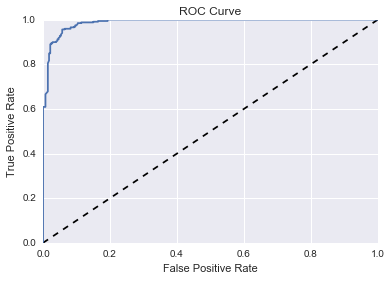

In [50]:
# Generating the ROC curve
y_pred_proba_pca = clf.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_pca)
roc_auc = auc(fpr, tpr)
print("AUC score is " + str(roc_auc))

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()


#### Now lets try and train our data using a TimeSeriesSplit which is specifically used for splitting the dataset to training and testing datasets.

#### By specifying the number of splits, we can split the data on a sample of 40%, 70% and 100% of the dataset.

#### The plots below shows the splits of the datasets and the respective number of samples in each split.


<generator object split at 0x10c8df8c0>
Observations: 995
Training Observations: 498
Testing Observations: 497
Observations: 1492
Training Observations: 995
Testing Observations: 497
Observations: 1989
Training Observations: 1492
Testing Observations: 497


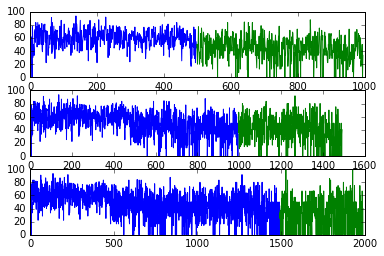

Observations: 995
Training Observations: 498
Testing Observations: 497
Observations: 1492
Training Observations: 995
Testing Observations: 497
Observations: 1989
Training Observations: 1492
Testing Observations: 497


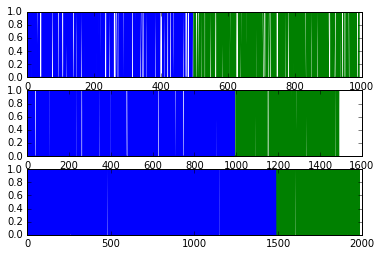

In [23]:
splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)
index = 1
print(splits.split(X))
for X_train_index, X_test_index in splits.split(X):
    X1_train = X.loc[X_train_index, :]
    X1_test = X.loc[X_test_index, :]
    print('Observations: %d' % (len(X1_train) + len(X1_test)))
    print('Training Observations: %d' % (len(X1_train)))
    print('Testing Observations: %d' % (len(X1_test)))
    pyplot.subplot(310 + index)
    pyplot.plot(X1_train['Objectivity'])
    pyplot.plot([None for i in X1_train['Objectivity']] + [x for x in X1_test['Objectivity']])
    index += 1
pyplot.show()

index = 1
for y_train_index, y_test_index in splits.split(y):
    y1_train = y[y_train_index]
    y1_test = y[y_test_index]
    print('Observations: %d' % (len(y1_train) + len(y1_test)))
    print('Training Observations: %d' % (len(y1_train)))
    print('Testing Observations: %d' % (len(y1_test)))
    pyplot.subplot(310 + index)
    pyplot.plot(y1_train)
    pyplot.plot([None for i in y1_train] + [x for x in y1_test])
    index += 1
pyplot.show()


#### Now, we will train our data on the new splits against all algorithms and check for accuracy.

#### We observe that all the algorithms are giving about 53% accuracy.

#### Lets scale our data using StandardScalar and see how the algorithm performs.

#### Scaling the data makes the accuracy increase to 57%. We can see the respective confusion matrix and accuracy scores below.

In [24]:
# Evaluate each algorithm for accuracy
results = []
names = []

for name, model in models:
    clf1 = model
    clf1.fit(X1_train, y1_train)
    y1_pred = clf.predict(X1_test)
    accu_score1 = accuracy_score(y1_test, y1_pred)
    print(name + ": " + str(accu_score))

LR: 0.537688442211
LDA: 0.537688442211
KNN: 0.537688442211
CART: 0.537688442211
NB: 0.537688442211
SVM: 0.537688442211
RF: 0.537688442211


In [26]:
# prepare the model Random Forest
scaler_rf = StandardScaler().fit(X1_train)
rescaledX_rf = scaler_rf.transform(X1_train)
model_rf = RandomForestClassifier(n_estimators=500)
model_rf.fit(rescaledX_rf, y1_train)
# estimate accuracy on validation dataset
rescaledValidationX_rf = scaler_rf.transform(X1_test)
predictions_rf = model_rf.predict(rescaledValidationX_rf)
print("accuracy score:")
print(accuracy_score(y1_test, predictions_rf))
print("confusion matrix: ")
print(confusion_matrix(y1_test, predictions_rf))
print("classification report: ")
print(classification_report(y1_test, predictions_rf))

accuracy score:
0.575452716298
confusion matrix: 
[[ 62 178]
 [ 33 224]]
classification report: 
             precision    recall  f1-score   support

          0       0.65      0.26      0.37       240
          1       0.56      0.87      0.68       257

avg / total       0.60      0.58      0.53       497



#### Plotting the roc auc curve and calculating the score shows a score of 0.5

#### As explained earlier, an auc score of 0.5 clearly suggests a bad model. Lets ignore Random Forests and not further proceed with fine tuning Random Forests.

roc auc is :0.5


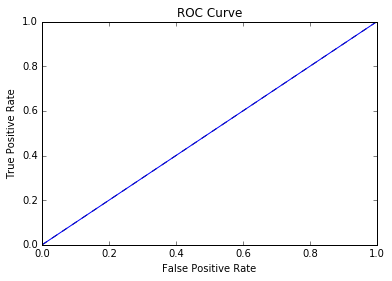

In [27]:
# Generating the ROC curve
y1_pred_proba = model_lda1.predict_proba(X1_test)[:,1]
fpr1, tpr1, thresholds1 = roc_curve(y1_test, y1_pred_proba)
roc_auc1 = auc(fpr1, tpr1)

# Plot ROC curve
print("roc auc is :" + str(roc_auc1))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr1, tpr1)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()

# ARIMA model:

Lets create an ARIMA model for our time series.

There are a certain checks that needs to be done before applying an ARIMA model on the dataset.

We need to check if there is a trend in our dataset. If there a trend, then we need to apply something called as differenciation to make our data stationary.

By plotting the outputs of the dataset, we see that there is a clear increasing trend.

This means we need to make our data stationary.


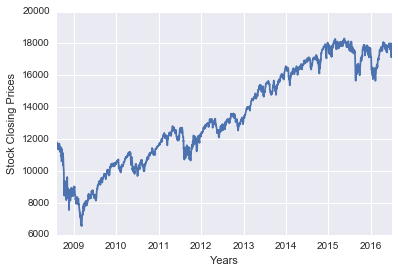

"\npyplot.plot(merged_dataframe['Date'].loc['2009-08-10':'2010-08-10'], merged_dataframe['Close'].loc['2009-08-10':'2010-08-10'])\npyplot.xlabel('Years')\npyplot.ylabel('Stock Closing Prices')\npyplot.show()\n"

In [23]:
pyplot.plot(merged_dataframe['Date'], merged_dataframe['Close'])
pyplot.xlabel('Years')
pyplot.ylabel('Stock Closing Prices')
pyplot.show()


In [30]:
merged_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1989 entries, 0 to 1988
Data columns (total 13 columns):
Date            1989 non-null datetime64[ns]
Subjectivity    1989 non-null float64
Objectivity     1989 non-null float64
Positive        1989 non-null float64
Negative        1989 non-null float64
Neutral         1989 non-null float64
Open            1989 non-null float64
High            1989 non-null float64
Low             1989 non-null float64
Close           1989 non-null float64
Volume          1989 non-null float64
Adj Close       1989 non-null float64
Label           1989 non-null int64
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 217.5 KB


#### Lets make the 'Date' column as index.

#### Now, we will plot the Autocorrelation plot to see estimate lag in our data.


In [31]:
merged_dataframe['Date'] = merged_dataframe['Date'].dt.strftime('%Y-%m')

Index([u'2008-08', u'2008-08', u'2008-08', u'2008-08', u'2008-08', u'2008-08',
       u'2008-08', u'2008-08', u'2008-08', u'2008-08',
       ...
       u'2016-06', u'2016-06', u'2016-06', u'2016-06', u'2016-06', u'2016-06',
       u'2016-06', u'2016-06', u'2016-06', u'2016-07'],
      dtype='object', name=u'Date', length=1989)
Date
2008-08    11734.320312
2008-08    11782.349609
2008-08    11642.469727
2008-08    11532.959961
2008-08    11615.929688
dtype: float64


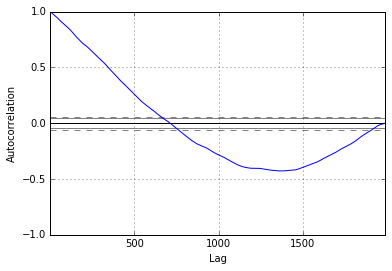

In [32]:
df_dateclose = pd.Series(merged_dataframe['Close'].values, index = merged_dataframe['Date'])
print(df_dateclose.index)
print(df_dateclose.head())
autocorrelation_plot(df_dateclose)
pyplot.show()

In [43]:
merged_dataframe['Close'].head()

0    11734.320312
1    11782.349609
2    11642.469727
3    11532.959961
4    11615.929688
Name: Close, dtype: float64

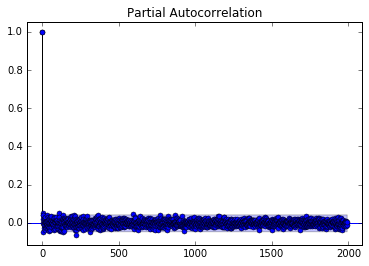

In [34]:
plot_acf(df_dateclose)
plot_pacf(df_dateclose)

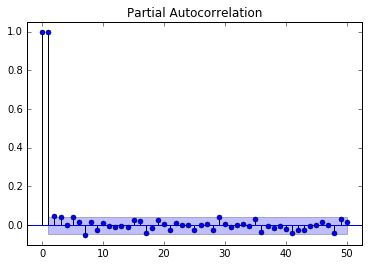

In [35]:
plot_pacf(df_dateclose, lags=50)

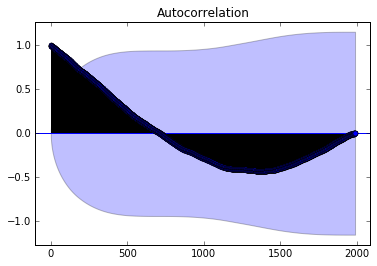

In [36]:
plot_acf(df_dateclose)

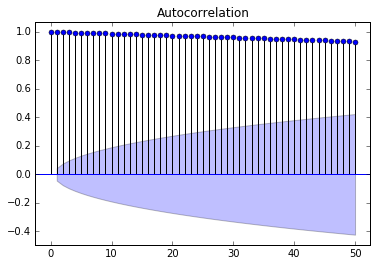

In [37]:
plot_acf(df_dateclose, lags=50)

In [38]:
arima_df = pd.DataFrame(merged_dataframe, index=merged_dataframe['Date'])

In [39]:
arima_df.index

Index([u'2008-08', u'2008-08', u'2008-08', u'2008-08', u'2008-08', u'2008-08',
       u'2008-08', u'2008-08', u'2008-08', u'2008-08',
       ...
       u'2016-06', u'2016-06', u'2016-06', u'2016-06', u'2016-06', u'2016-06',
       u'2016-06', u'2016-06', u'2016-06', u'2016-07'],
      dtype='object', name=u'Date', length=1989)

#### Lets look at how our ARIMA model performs with different values of p,d,q

#### Finding out the best parameters just by looking at the plots is very difficult and can sometimes lead to bad predictions.

#### One thing that can be done is performing the training over a range of parameters and checking which parameter are performing the best.

#### We will do this by looping over the combination of a different range of parameters and check which of the parameter have the least mean squared error.
    

In [40]:

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df_dateclose.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=20668304.955
ARIMA(0, 0, 1) MSE=5461790.075
ARIMA(0, 0, 2) MSE=1772079.150
ARIMA(0, 1, 0) MSE=20795.457
ARIMA(0, 1, 1) MSE=20924.395
ARIMA(0, 1, 2) MSE=20943.655
ARIMA(0, 2, 0) MSE=42509.418
ARIMA(0, 2, 1) MSE=20868.506
ARIMA(1, 0, 0) MSE=20855.468
ARIMA(1, 1, 0) MSE=20900.617
ARIMA(1, 1, 1) MSE=20954.341
ARIMA(1, 2, 0) MSE=31795.461
ARIMA(2, 1, 0) MSE=20958.802
ARIMA(2, 2, 0) MSE=28045.841
ARIMA(2, 2, 1) MSE=21049.420
ARIMA(4, 1, 0) MSE=20970.865
ARIMA(4, 2, 0) MSE=25930.053
ARIMA(4, 2, 1) MSE=21060.106
ARIMA(6, 1, 0) MSE=21007.929
ARIMA(6, 2, 0) MSE=24556.223
ARIMA(6, 2, 2) MSE=21140.191
ARIMA(8, 1, 0) MSE=21071.021
ARIMA(8, 2, 0) MSE=23686.402
ARIMA(8, 2, 1) MSE=21165.232
ARIMA(10, 1, 0) MSE=21141.683
ARIMA(10, 2, 0) MSE=23367.557
ARIMA(10, 2, 1) MSE=21234.113
Best ARIMA(0, 1, 0) MSE=20795.457


#### Based on our code, we have found out that the ARIMA model is best when the parameters are 0,1,0 for p,d,q respectively.

#### The mean squared error of the model training is about 20000 which is considerably ok as we are dealing with a huge set of numbers.


#### Now ,lets predict the values based on our the model we fit in the previous cell on the test set and plot a graph of the predicted and actual values.

#### We can observe below that the expected and predicted value are very close and it looks like for each of the samples, the previous expected value is much closer to the current predicted.
   
#### The plot below shows the predicted and actual values in red and blue respectively.

#### Its very smooth and seems like the model is doing a good job, but it can definitely do better with a little bit of tweaking.


predicted=15416.136340, expected=15509.209961
predicted=15512.087163, expected=15570.280273
predicted=15573.201796, expected=15568.929688
predicted=15571.847960, expected=15680.349609
predicted=15683.350392, expected=15618.759766
predicted=15621.711468, expected=15545.750000
predicted=15548.644024, expected=15615.549805
predicted=15618.494592, expected=15639.120117
predicted=15642.080541, expected=15618.219727
predicted=15621.162075, expected=15746.879883
predicted=15749.917400, expected=15593.980469
predicted=15596.900030, expected=15761.780273
predicted=15764.824460, expected=15783.099609
predicted=15786.157599, expected=15750.669922
predicted=15753.701129, expected=15821.629883
predicted=15824.712319, expected=15876.219727
predicted=15879.340978, expected=15961.700195
predicted=15964.883463, expected=15976.019531
predicted=15979.211178, expected=15967.030273
predicted=15970.212762, expected=15900.820312
predicted=15903.950665, expected=16009.990234
predicted=16013.200196, expected=1

predicted=17125.547317, expected=17079.570312
predicted=17083.077692, expected=17098.449219
predicted=17101.966681, expected=17067.560547
predicted=17071.055462, expected=17078.279297
predicted=17081.778943, expected=17069.580078
predicted=17073.071740, expected=17137.359375
predicted=17140.893083, expected=17111.419922
predicted=17114.934365, expected=17013.869141
predicted=17017.317573, expected=17068.710938
predicted=17072.192916, expected=17049.000000
predicted=17052.466849, expected=16987.509766
predicted=16990.934270, expected=17031.140625
predicted=17034.591322, expected=17131.970703
predicted=17135.484798, expected=17156.849609
predicted=17160.377605, expected=17265.990234
predicted=17269.586898, expected=17279.740234
predicted=17283.343496, expected=17172.679688
predicted=17176.211090, expected=17055.869141
predicted=17059.322450, expected=17210.060547
predicted=17213.611611, expected=16945.800781
predicted=16949.178280, expected=17113.150391
predicted=17116.634089, expected=1

predicted=18019.586526, expected=18119.779297
predicted=18123.474586, expected=18144.070312
predicted=18147.777513, expected=17966.070312
predicted=17969.672480, expected=17890.359375
predicted=17893.915723, expected=17946.679688
predicted=17950.266501, expected=17596.349609
predicted=17599.732199, expected=17619.509766
predicted=17622.903762, expected=17757.910156
predicted=17761.381966, expected=17730.109375
predicted=17733.563171, expected=17683.580078
predicted=17687.005098, expected=17776.910156
predicted=17780.386905, expected=17515.419922
predicted=17518.744304, expected=17548.619141
predicted=17551.960692, expected=17760.410156
predicted=17763.871437, expected=17977.679688
predicted=17981.263706, expected=18053.580078
predicted=18057.205586, expected=18050.169922
predicted=18053.791395, expected=18120.250000
predicted=18123.909559, expected=18086.449219
predicted=18090.087323, expected=18100.410156
predicted=18104.054169, expected=17919.289062
predicted=17922.827374, expected=1

predicted=17900.647670, expected=18004.160156
predicted=18007.400383, expected=18053.599609
predicted=18056.863700, expected=18096.269531
predicted=18099.553965, expected=17982.519531
predicted=17985.743576, expected=18003.750000
predicted=18006.983331, expected=17977.240234
predicted=17980.458234, expected=17990.320312
predicted=17993.543393, expected=18041.550781
predicted=18044.798582, expected=17830.759766
predicted=17833.897409, expected=17773.640625
predicted=17776.747271, expected=17891.160156
predicted=17894.325626, expected=17750.910156
predicted=17754.001930, expected=17651.259766
predicted=17654.298769, expected=17660.710938
predicted=17663.753233, expected=17740.630859
predicted=17743.712599, expected=17705.910156
predicted=17708.972510, expected=17928.349609
predicted=17931.524406, expected=17711.119141
predicted=17714.181026, expected=17720.500000
predicted=17723.565120, expected=17535.320312
predicted=17538.289094, expected=17710.710938
predicted=17713.767915, expected=1

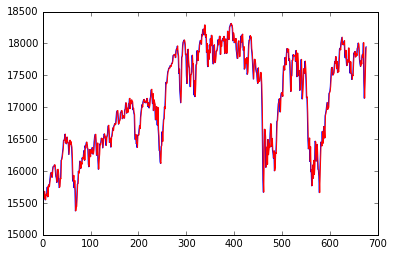

In [47]:
X = df_dateclose.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In the graph above graph, the red line shows the predictions and the blue line show the actual values. The predictions are performed on the testing set and the graph above is the testing set. We can also observe the actual and the predicted values for the training and the testing set. The model is clean and red and blue lines are overlapping on one another clearly explaining that the predictions are quite accurate and that this model can further be used for performing predictions. In total we have an XGBoost model which has an accuracy of 94% and an ARIMA model which can be used to predict the actual prices.

